In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

from StarryStarryProcess import *
from DistributionFunctions import *

starry.config.quiet = True
np.random.seed(1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
%matplotlib inline

In [3]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
# lc_collection.plot();

In [4]:
search_result.year

array([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011,
       2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013,
       2013, 2013, 2013, 2013])

In [5]:
all_lc = lc_collection.stitch()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

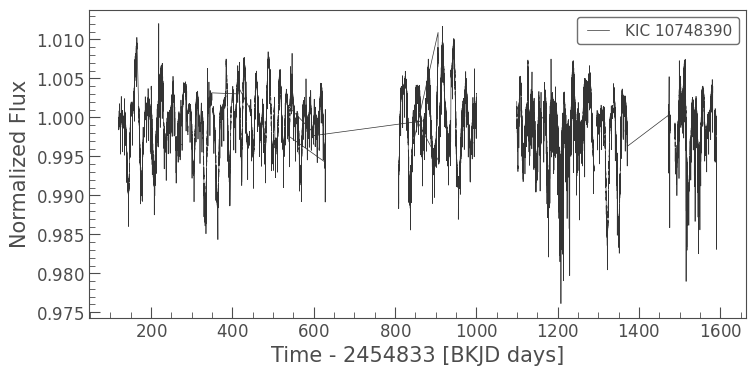

In [6]:
all_lc.plot()

# Cleaning the data

In [7]:
all_lc=all_lc.remove_nans()

In [8]:
all_lc = all_lc[all_lc.quality==0]

In [9]:
all_lc['time'].format = 'iso'

In [10]:
all_lc['time'].value[0].split('-')[0]

'2009'

In [11]:
mask2010 = [i.split('-')[0]=='2010' and i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in all_lc['time'].value]
mask2009a = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in all_lc['time'].value]
mask2009b = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in all_lc['time'].value]
mask2012 = [i.split('-')[0]=='2012' and i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in all_lc['time'].value]

In [12]:
all_lc['time'].format = 'bkjd'

In [13]:
lc2010 = all_lc[mask2010]
lc2009a = all_lc[mask2009a]
lc2009b = all_lc[mask2009b]
lc2012 = all_lc[mask2012]

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

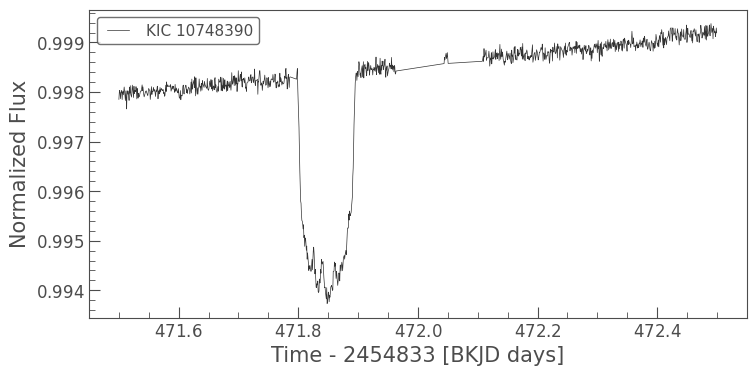

In [14]:
lc2010.plot()

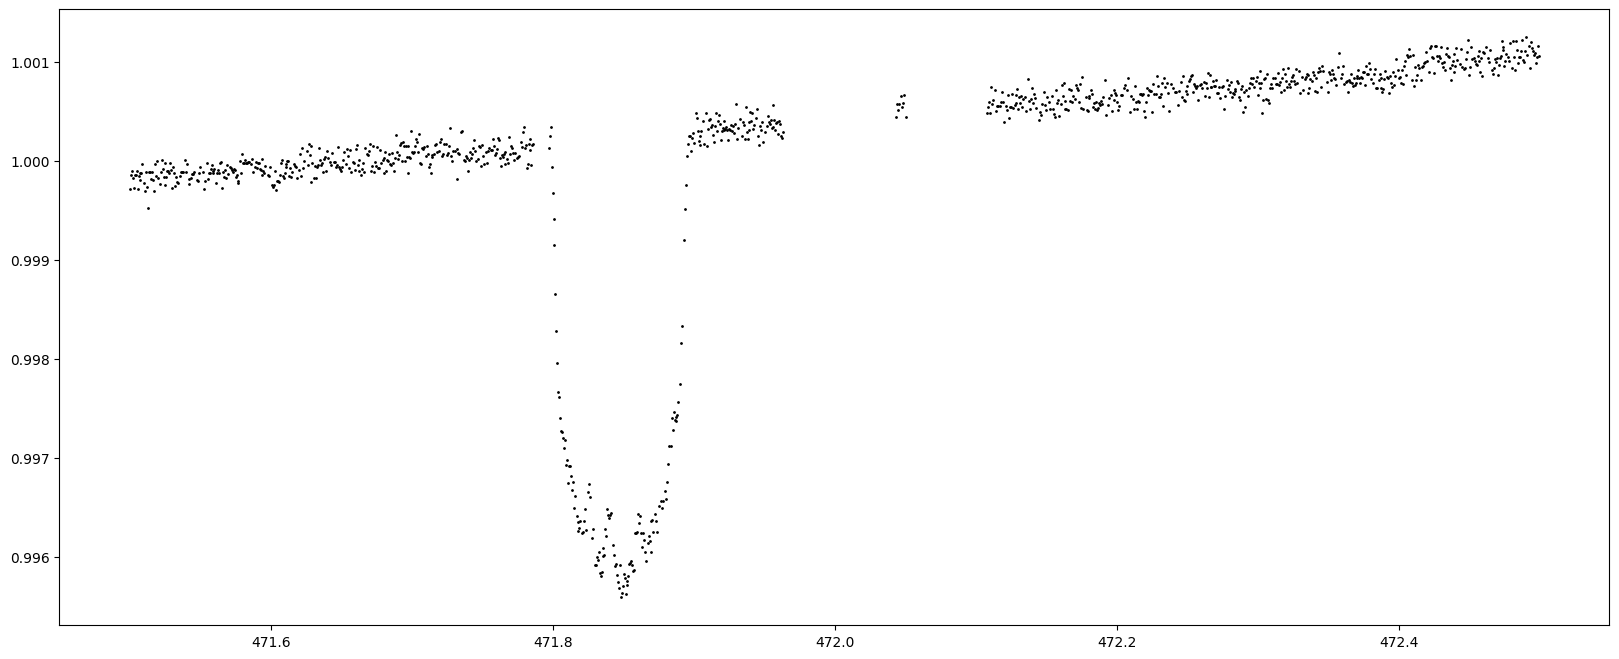

In [15]:
t = lc2010.time.value #saving the times
flux = np.array(lc2010.pdcsap_flux.value) # saving the fluxes with PDCSAP
mean_flux = np.mean(np.array(lc2010.pdcsap_flux.value))
flux_obs = flux / mean_flux

sigma_flux = np.array(lc2010.pdcsap_flux_err.value) / mean_flux

data = list(zip(t, flux_obs, sigma_flux))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes, sorted_errors = zip(*sorted_data)

t = np.array(sorted_times)
flux_obs = np.array(sorted_fluxes)
sigma_flux = np.array(sorted_errors)

plt.figure(figsize=(20, 8))
plt.plot(t, flux_obs, "k.", ms=2)

In [16]:
def gp_model(array, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot, 
            t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        # for n, chunk in enumerate(array):
        
        #     t = chunk[0]
        #     flux = chunk[1]
        #     err = chunk[2]

        #     ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        #     pm.Potential('marginal_likelihood_'+str(n), ssp_model.marginal_likelihood(t, flux, err))

        t = array[0]
        flux = array[1]
        err = array[2]

        ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

In [17]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

In [18]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

mHATP11b = 0.0736 * mJ # grams
mHATP11 = 0.809 * mSun
rHATP11b = 0.389 * rJ # cm
rHATP11 = 0.683 * rSun 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


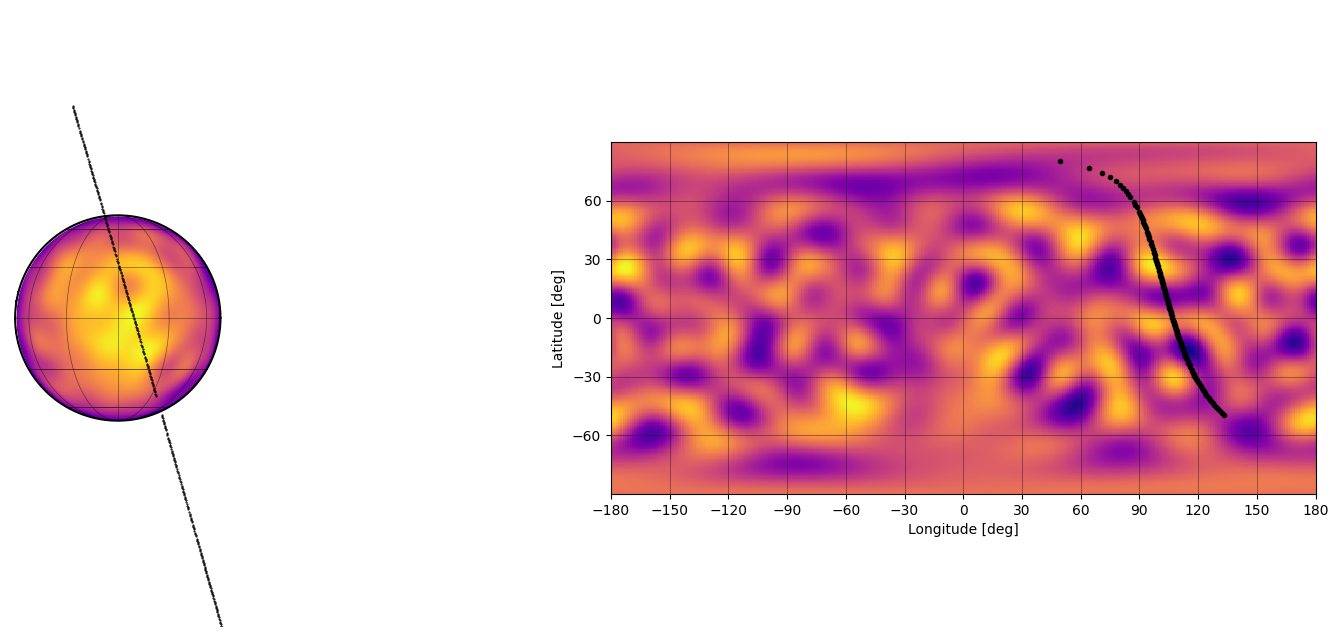

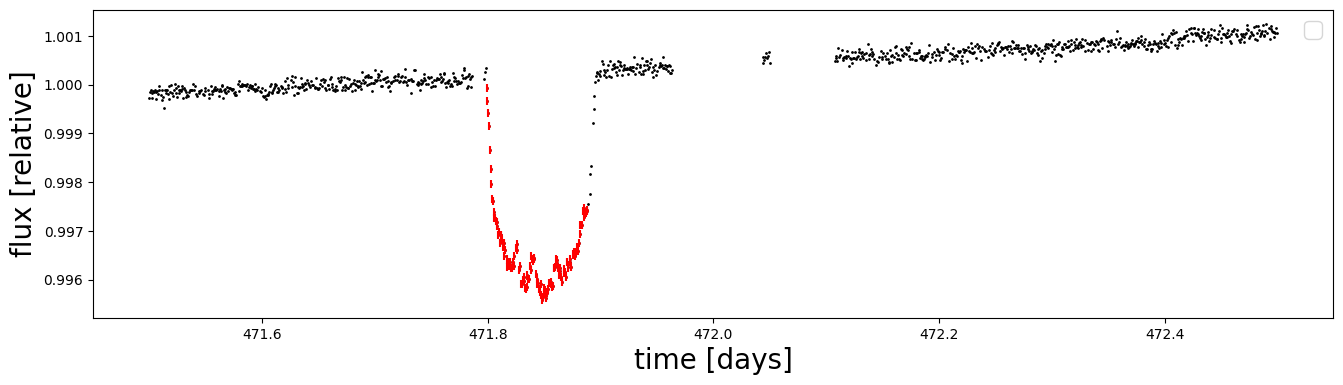

In [19]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 89.05, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.9]},
    # "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.Omega": {"truth": 106.0, "dist": Angle},
    "planet.porb": {"truth": 4.887802443, "dist": Period},
    "planet.t0": {"truth": 124.81, "dist": Uniform, "args": [124.6, 125.1]},
    "planet.r": {"truth": rHATP11b / rSun, "dist": Logarithmic},
    "planet.m": {"truth":  mHATP11b / mSun, "dist": Uniform, "args": [0.00001, 0.0001]},

    "star.inc": {"truth": 90, "dist": Stellar_Ang},
    "star.m": {"truth": mHATP11 / mSun, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.646, "dist": Uniform, "args": [0.0, 0.8]},
    "star.u2": {"truth": 0.048, "dist": Uniform, "args": [0.0, 0.1]},
    "star.prot": {"truth": 30, "dist": Uniform, "args": [29.99, 30.05]},
    # "star.obl": {"truth": -106.0, "dist": Stellar_Ang},
    "star.obl": {"truth": 0.0, "dist": Stellar_Ang},
    "star.r": {"truth": rHATP11 / rSun, "dist": Uniform, "args": [0.1, 1]},

    "gp.r": {"truth": 6, "dist": Uniform, "args": [5.0, 35.0]},
    "gp.dr": {"truth": 1.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.3, "dist": Uniform, "args": [0.1, 0.9]},
    "gp.n": {"truth": 3, "dist": Uniform, "args": [0, 60]},
    "gp.mu": {"truth": 15, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 30, "dist": Uniform, "args": [1.0, 50]}
}

t_, flux_, sigma_flux_ = bin_out_of_transit(t, flux_obs, sigma_flux, params, dt=0.045, binsize=1000)

# Initializing the time
Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

dt = 0.6
idx = np.zeros(len(t_), dtype=bool)
ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
for n in range(ntransits):
    t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
    idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
t_in = t_[idx]
t_out = t_[~idx]
flux_in = flux_[idx]
flux_out = flux_[~idx]

nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Plot the data

map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    mu=params["gp.mu"]["truth"],
    sigma=params["gp.sigma"]["truth"],
    r=params["gp.r"]["truth"],
    dr=params["gp.dr"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

nt = len(t_)
nylm = len(map.y.eval())
ssp = StarryStarryProcess(sys, sp, len(t), nylm)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_obs, 'k.', ms=2, alpha=1)
ax.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.', ms=2, color='red')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);
plt.show()

In [33]:
# Set some free params & get the model
p = dict(params)

p['star.r']['free'] = True
p['planet.r']['free'] = True
p['star.u1']['free'] = True
p['star.u2']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(np.array([t, flux_obs, sigma_flux]), p)

In [34]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,inc}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwis


planet.r: 0.05113791160825371 [0.03904859694976592]
star.u1: 0.5639289843311986 [0.646]
star.u2: 0.04732118134078631 [0.048]
star.r: 0.8852325413436627 [0.683]


message: Desired error not necessarily achieved due to precision loss.
logp: -980.044377728765 -> 8241.849532492497


In [36]:
map_soln

{'planet.rlog_interval__': array(0.82153116),
 'star.r_interval__': array(1.92307192),
 'star.u1_interval__': array(0.87079566),
 'star.u2_interval__': array(-0.10725545),
 'planet.rlog': array(-2.97322915),
 'planet.r': array(0.05113791),
 'star.r': array(0.88523254),
 'star.u1': array(0.56392898),
 'star.u2': array(0.04732118)}

In [37]:
for x in free:
    params[x]['truth'] = map_soln[x]

In [ ]:
nsamples = 100
for k in range(nsamples):
    ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]
    map[:, :] = ylm_draw
    fig, ax = plt.subplots(1, figsize=(20, 8))
    filename = 'map-one-transit' + str(k)

    map.show(ax=ax, file=filename, projection='moll', alpha=1)

In [21]:
#!/usr/bin/env python3
import gc
import logging
import subprocess
import sys
import tempfile
from pathlib import Path

import numpy as np

def make_animation(frame_rate: float) -> None:
    print("Rendering animation...")
    subprocess.run(
        [
            "/Users/sabina/Downloads/ffmpeg",
            "-y",
            "-r",
            str(frame_rate),
            "-pattern_type",
            "glob",
            "-i",
            "*.png",
            *"-c:v libx264 -pix_fmt yuv420p -vf".split(),
            "fps=30, pad=ceil(iw/2)*2:ceil(ih/2)*2",
            "out.mp4",
        ],
        check=True,
    )


# for path in sorted(Path("castro_outputs").glob("v_*_drho_*")):
make_animation(frame_rate=6)

Rendering animation...


ffmpeg version N-106378-gfa989df1c6-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

In [20]:
nsamples = 100
surface_maps = []
ylms = []
pixels = []
map = starry.Map(15, 2)
for k in range(nsamples):
    ylms.append(ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:])
    map[:,:] = ylms[k]
    lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=4)
    pixels.append(Y2P.dot(ylms[k]))
    # map.show(projection='moll')
    surface_maps.append(map)

# Calculate the average surface map
average_ylm = np.mean(ylms, axis=0)

# Calculate the variance of the pixels between the surface maps
variance_map = np.var(ylms, axis=0)

In [21]:
pixels = np.array(pixels)

In [22]:
ave_ps = np.mean(pixels, axis=0)

In [23]:
var_ps = np.var(pixels, axis=0)

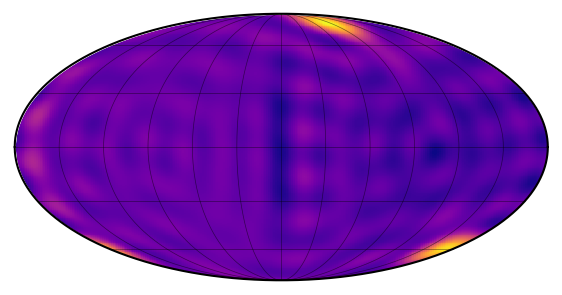

In [24]:
map[:,:] = average_ylm
map.show(projection='moll')

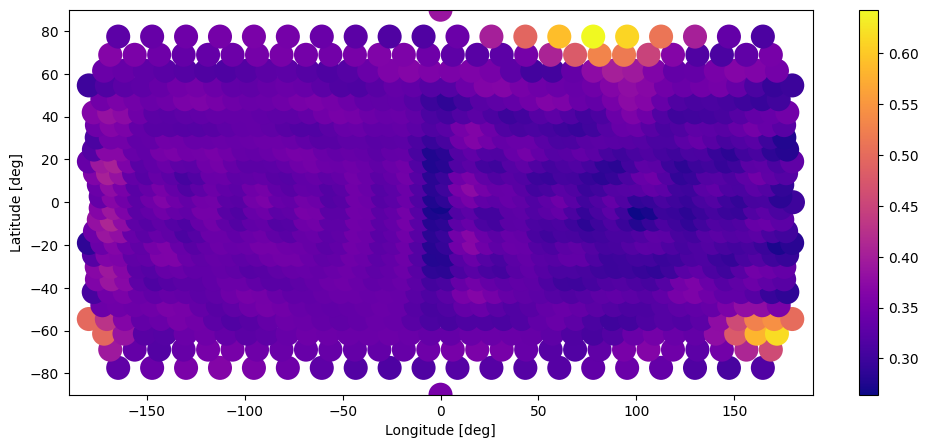

In [25]:
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c=ave_ps, alpha=1, ec="none", cmap="plasma")
plt.colorbar(im)
ax.set_xlim(-190, 190)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]");

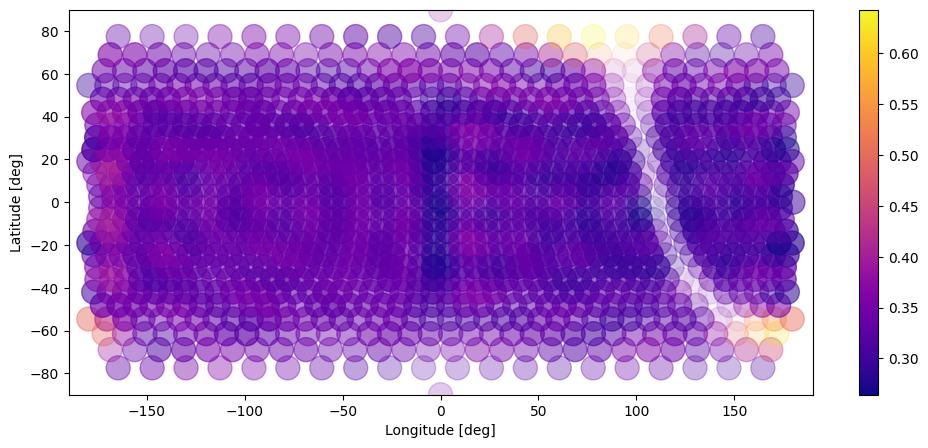

In [26]:
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c=ave_ps, alpha=var_ps / np.max(var_ps), cmap="plasma")
plt.colorbar(im)
ax.set_xlim(-190, 190)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]");

In [27]:
pixel_precision = 1/var_ps
rescaled_pixel_precision = (pixel_precision - np.min(pixel_precision))/(np.max(pixel_precision) - np.min(pixel_precision))

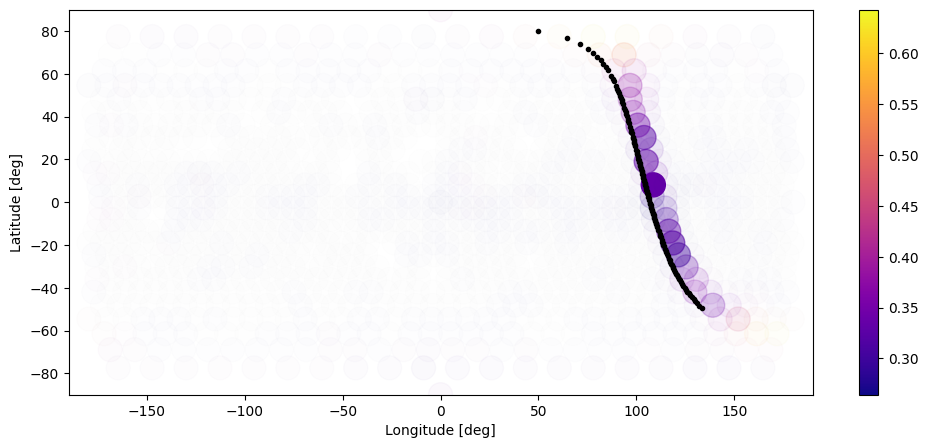

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 5))
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat1 = 180 / np.pi * np.arcsin(yo[idx])
lon1 = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon1 = (lon1 + 180) % 360 - 180
mask = np.append(np.array(lon1[1:] > lon1[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
im = ax.scatter(lon, lat, s=300, c=ave_ps, alpha=rescaled_pixel_precision, cmap="plasma")
ax.plot(lon1, lat1 + mask, "k.");
plt.colorbar(im)
ax.set_xlim(-190, 190)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]");

In [29]:
z_score = (ave_ps - np.mean(ave_ps)) / np.sqrt(var_ps)

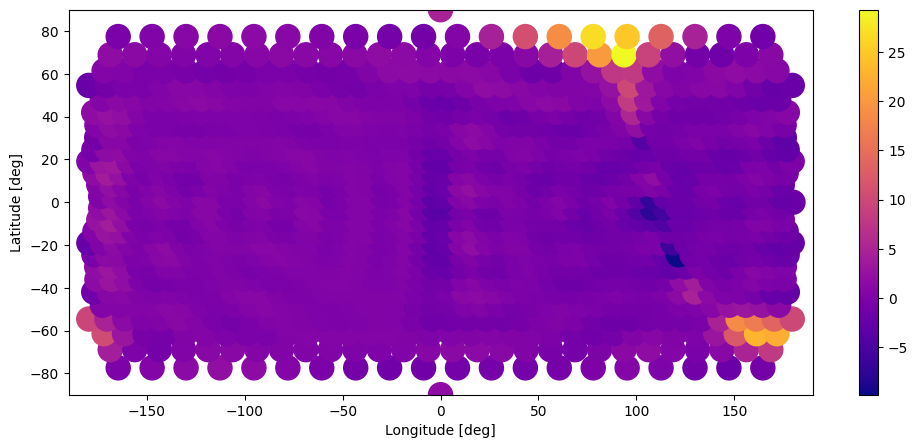

In [30]:
fig, ax = plt.subplots(1, figsize=(12, 5))
im = ax.scatter(lon, lat, s=300, c=z_score, cmap="plasma")
plt.colorbar(im)
ax.set_xlim(-190, 190)
ax.set_ylim(-90, 90)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]");

In [31]:
params["gp.mu"]["truth"]

15

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


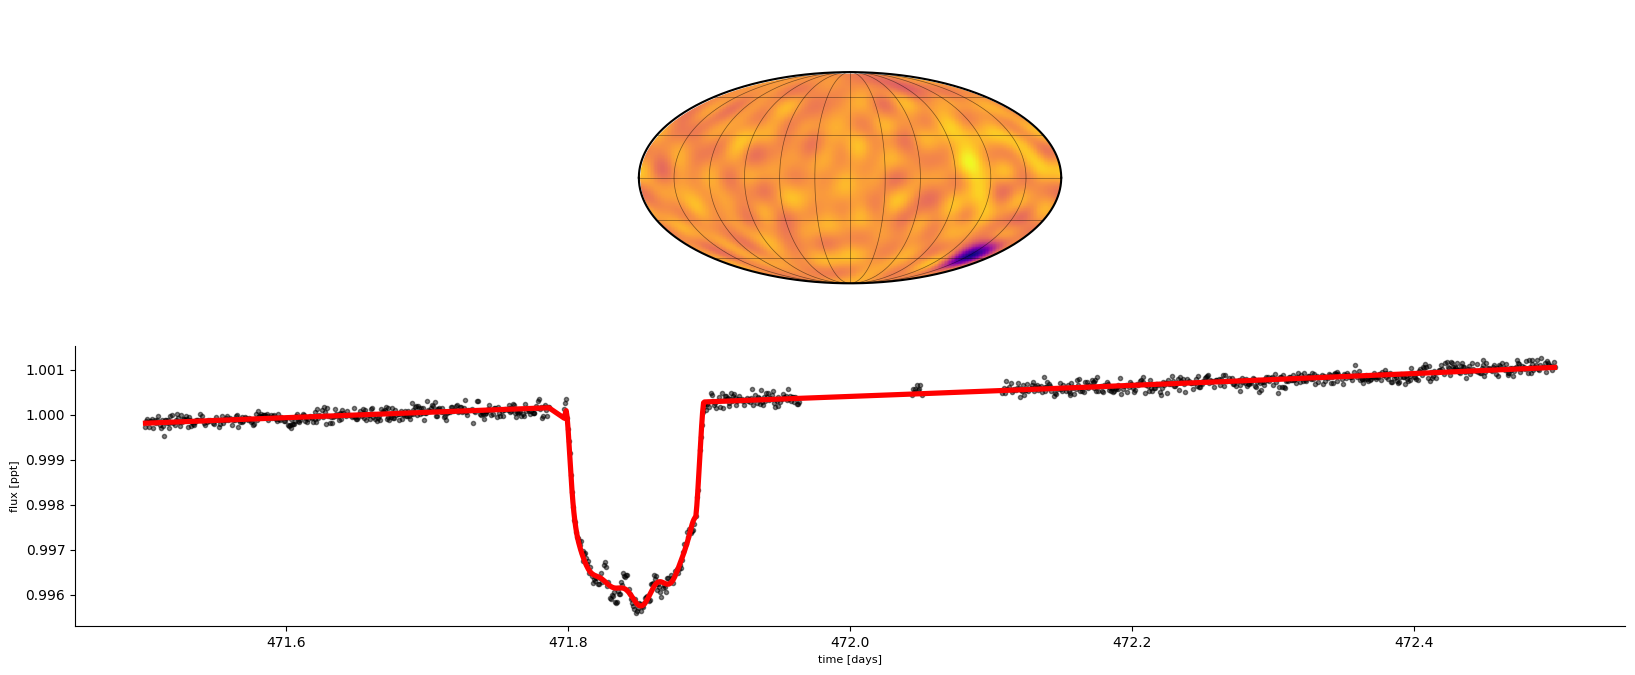

In [38]:
# plotting 5 samples
nsamples = 1
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
)

for k in range(nsamples):
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]['truth'], 
                          obl=params["star.obl"]["truth"], inc=params["star.inc"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]['truth'],
        t0=params["planet.t0"]['truth'],
        r=params["planet.r"]['truth'],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]['truth'],
    )


    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0], projection="moll")
    ax[0].set_ylim(-1.5, 2.25)
    ax[0].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1].plot(t, flux_obs, 'k.', alpha=0.5)
    ax[1].plot(t, flux_samples, 'r-', lw=3.75, alpha=1)

    if k == 0:
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].set_xlabel("time [days]", fontsize=8)
        ax[1].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1].axis("off")
    
    # plt.xlim(425,430)
